In [1]:
%matplotlib inline
import numpy as np
from copy import deepcopy
import argparse
import torch

import sys
import os
# ROOT = os.path.dirname(os.path.realpath(__file__))
sys.path.append("../")
from mddpg.Mddpg import MDDPG
from common.util import *
from common.grid_world import GridWorld
from mddpg.evaluator import Evaluator
os.environ['CUDA_VISIBLE_DEVICE'] = '0'

In [2]:
def train(num_iterations, env, evaluate, validate_steps, output, max_episode_length=None, debug=False):
    agent.is_training = True
    step = episode = episode_steps = 0
    episode_reward = 0
    observation = None
    while step < num_iterations:
        # reset if it is the start of episode
        if observation is None:
            observation = deepcopy(env.reset())
            agent.reset(observation)

        # agent pick action
        if step <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(observation)

        # env response with next_observation, reward, done
        obs_next, reward, done, info = env.step(action)
        obs_next = deepcopy(obs_next)
        if max_episode_length and episode_steps >= max_episode_length - 1:
            done = True

        # agent observe and update policy
        agent.observe(reward, obs_next, done)
        if step > args.warmup:
            agent.update_policy()

        # evaluate
        if evaluate is not None and validate_steps > 0 and step % validate_steps == 0:
            policy = lambda x: agent.select_action(x, decay_epsilon=False)
            validate_reward = evaluate(env, policy, debug=False, visualize=False)
            if debug:
                prYellow('[Evaluate] Step_{:07d}: mean_reward:{}'.format(step, validate_reward))

        # save intermediate model
        if step % int(num_iterations/3) == 0:
            agent.save_model(output)

        #update
        step += 1
        episode_steps += 1
        for i in reward:
            episode_reward += i
        observation = deepcopy(obs_next)

        if done:
            if debug:
                if step%100 == 0:
                    prGreen('#{}: episode_reward:{} step:{}'.format(episode, episode_reward, step))
            agent.memory.add(
                observation,
                agent.select_action(observation),
                reward,
                obs_next,
                False
            )

            # reset
            observation = None
            episode_steps = 0
            episode_reward = 0
            episode += 1


def test(num_episodes, agent, env, evaluate, model_path, visualize=True, debug=False):
    agent.load_weights(model_path)
    agent.is_training = False
    agent.eval()
    policy = lambda x: agent.select_action(x, decay_epsilon=False)

    for i in range(num_episodes):
        validate_reward = evaluate(env, policy, debug=debug, visualize=visualize, save=False)
        if debug:
            prYellow('[Evaluate] #{}: mean_reward:{}'.format(i, validate_reward))


 [Evaluate] Step_0000000: mean_reward:-0.9999999999999998
 #99: episode_reward:-1.0999999999999999 step:100


../common/util.py:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  torch.from_numpy(ndarray), volatile=volatile, requires_grad=requires_grad
../mddpg/Mddpg.py:73: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_q_values.volatile = False


 #199: episode_reward:-1.0999999999999999 step:200
 #299: episode_reward:-0.9999999999999999 step:300
 #399: episode_reward:-0.9999999999999999 step:400
 #499: episode_reward:-0.9999999999999999 step:500
 #599: episode_reward:-0.09999999999999995 step:600
 #699: episode_reward:-0.9999999999999999 step:700
 #799: episode_reward:-0.9999999999999999 step:800
 #899: episode_reward:-0.9999999999999999 step:900
 #999: episode_reward:-0.9999999999999999 step:1000
 #1099: episode_reward:-1.1 step:1100
 #1199: episode_reward:-0.9999999999999999 step:1200
 #1299: episode_reward:-1.3 step:1300
 #1399: episode_reward:-1.2000000000000002 step:1400
 #1499: episode_reward:-0.9999999999999999 step:1500
 #1599: episode_reward:-0.9999999999999999 step:1600
 #1699: episode_reward:-1.1 step:1700
 #1799: episode_reward:-1.2000000000000002 step:1800
 #1899: episode_reward:-1.0999999999999999 step:1900
 #1999: episode_reward:-1.3 step:2000
 [Evaluate] Step_0002000: mean_reward:-1.0650000000000002
 #2099: epi

 #13499: episode_reward:-0.9999999999999999 step:13500
 #13599: episode_reward:1.0999999999999999 step:13600
 #13699: episode_reward:-1.0999999999999999 step:13700
 #13799: episode_reward:-1.0999999999999999 step:13800
 #13899: episode_reward:-1.0999999999999999 step:13900
 #13999: episode_reward:-1.1 step:14000
 [Evaluate] Step_0014000: mean_reward:-1.1500000000000001
 #14099: episode_reward:-1.0999999999999999 step:14100
 #14199: episode_reward:-1.2 step:14200
 #14299: episode_reward:-1.2000000000000002 step:14300
 #14399: episode_reward:-1.1 step:14400
 #14499: episode_reward:-1.0999999999999999 step:14500
 #14599: episode_reward:-1.0999999999999999 step:14600
 #14699: episode_reward:-1.3 step:14700
 #14799: episode_reward:-1.0999999999999999 step:14800
 #14899: episode_reward:-1.2000000000000002 step:14900
 #14999: episode_reward:-1.1 step:15000
 #15099: episode_reward:-1.2999999999999998 step:15100
 #15199: episode_reward:-0.9999999999999999 step:15200
 #15299: episode_reward:-1.2

 #26699: episode_reward:-1.0999999999999999 step:26700
 #26799: episode_reward:-1.3000000000000003 step:26800
 #26899: episode_reward:-1.2000000000000002 step:26900
 #26999: episode_reward:-1.0999999999999999 step:27000
 #27099: episode_reward:-8.326672684688674e-17 step:27100
 #27199: episode_reward:-1.1 step:27200
 #27299: episode_reward:-1.2000000000000002 step:27300
 #27399: episode_reward:-1.0999999999999999 step:27400
 #27499: episode_reward:-1.2 step:27500
 #27599: episode_reward:2.7755575615628914e-17 step:27600
 #27699: episode_reward:-1.0999999999999999 step:27700
 #27799: episode_reward:0.10000000000000003 step:27800
 #27899: episode_reward:-1.2000000000000004 step:27900
 #27999: episode_reward:-1.0999999999999999 step:28000
 [Evaluate] Step_0028000: mean_reward:-1.03
 #28099: episode_reward:-0.9999999999999999 step:28100
 #28199: episode_reward:-1.0999999999999999 step:28200
 #28299: episode_reward:-1.2 step:28300
 #28399: episode_reward:-0.0999999999999999 step:28400
 #284

/home/jikunkang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 #40099: episode_reward:-1.2000000000000002 step:40100
 #40199: episode_reward:-1.0999999999999999 step:40200
 #40299: episode_reward:-0.19999999999999993 step:40300
 #40399: episode_reward:-1.0999999999999999 step:40400
 #40499: episode_reward:5.551115123125783e-17 step:40500
 #40599: episode_reward:-1.2 step:40600
 #40699: episode_reward:-1.0999999999999999 step:40700
 #40799: episode_reward:-1.2000000000000002 step:40800
 #40899: episode_reward:-1.2 step:40900
 #40999: episode_reward:-1.0999999999999999 step:41000
 #41099: episode_reward:-1.0999999999999999 step:41100
 #41199: episode_reward:-0.9999999999999999 step:41200
 #41299: episode_reward:-1.1 step:41300
 #41399: episode_reward:-1.2000000000000004 step:41400
 #41499: episode_reward:-1.0999999999999999 step:41500
 #41599: episode_reward:-1.0999999999999999 step:41600
 #41699: episode_reward:-1.1 step:41700
 #41799: episode_reward:-1.1 step:41800
 #41899: episode_reward:-1.4000000000000001 step:41900
 #41999: episode_reward:-1.

 #53299: episode_reward:-1.0999999999999999 step:53300
 #53399: episode_reward:-1.2 step:53400
 #53499: episode_reward:-0.9999999999999999 step:53500
 #53599: episode_reward:-1.2999999999999998 step:53600
 #53699: episode_reward:-1.4000000000000001 step:53700
 #53799: episode_reward:-1.2000000000000002 step:53800
 #53899: episode_reward:-1.2000000000000002 step:53900
 #53999: episode_reward:-1.3 step:54000
 [Evaluate] Step_0054000: mean_reward:-1.0600000000000003
 #54099: episode_reward:-1.2 step:54100
 #54199: episode_reward:-1.0999999999999999 step:54200
 #54299: episode_reward:-1.3 step:54300
 #54399: episode_reward:-1.1 step:54400
 #54499: episode_reward:-1.3 step:54500
 #54599: episode_reward:-1.0999999999999999 step:54600
 #54699: episode_reward:-1.2 step:54700
 #54799: episode_reward:2.7755575615628914e-17 step:54800
 #54899: episode_reward:-0.19999999999999993 step:54900
 #54999: episode_reward:-1.2 step:55000
 #55099: episode_reward:-1.2 step:55100
 #55199: episode_reward:-1.2

 #66499: episode_reward:-1.3000000000000005 step:66500
 #66599: episode_reward:-0.9999999999999999 step:66600
 #66699: episode_reward:-1.2000000000000002 step:66700
 #66799: episode_reward:-1.3 step:66800
 #66899: episode_reward:-1.1 step:66900
 #66999: episode_reward:8.326672684688674e-17 step:67000
 #67099: episode_reward:-1.0999999999999999 step:67100
 #67199: episode_reward:0.10000000000000014 step:67200
 #67299: episode_reward:-1.3 step:67300
 #67399: episode_reward:-1.1 step:67400
 #67499: episode_reward:-0.09999999999999987 step:67500
 #67599: episode_reward:-1.2000000000000002 step:67600
 #67699: episode_reward:-1.3 step:67700
 #67799: episode_reward:-1.0999999999999999 step:67800
 #67899: episode_reward:-1.2 step:67900
 #67999: episode_reward:-1.0999999999999999 step:68000
 [Evaluate] Step_0068000: mean_reward:-1.04
 #68099: episode_reward:-1.0999999999999999 step:68100
 #68199: episode_reward:-1.2 step:68200
 #68299: episode_reward:-1.2 step:68300
 #68399: episode_reward:-1.1

 #79899: episode_reward:-1.0999999999999999 step:79900
 #79999: episode_reward:-1.2 step:80000
 [Evaluate] Step_0080000: mean_reward:-1.0100000000000002
 #80099: episode_reward:-0.0999999999999999 step:80100
 #80199: episode_reward:-1.0999999999999999 step:80200
 #80299: episode_reward:-0.1 step:80300
 #80399: episode_reward:-1.0999999999999999 step:80400
 #80499: episode_reward:-1.2000000000000002 step:80500
 #80599: episode_reward:8.326672684688674e-17 step:80600
 #80699: episode_reward:-1.2000000000000002 step:80700
 #80799: episode_reward:-1.2000000000000002 step:80800
 #80899: episode_reward:-0.9999999999999999 step:80900
 #80999: episode_reward:-1.2999999999999998 step:81000
 #81099: episode_reward:-1.1 step:81100
 #81199: episode_reward:-1.3 step:81200
 #81299: episode_reward:-1.1 step:81300
 #81399: episode_reward:-1.1 step:81400
 #81499: episode_reward:-1.3000000000000003 step:81500
 #81599: episode_reward:-0.1 step:81600
 #81699: episode_reward:-1.0999999999999999 step:81700


 #93099: episode_reward:-1.2 step:93100
 #93199: episode_reward:-1.1 step:93200
 #93299: episode_reward:2.7755575615628914e-17 step:93300
 #93399: episode_reward:2.7755575615628914e-17 step:93400
 #93499: episode_reward:-1.0999999999999999 step:93500
 #93599: episode_reward:-1.3000000000000003 step:93600
 #93699: episode_reward:-1.2 step:93700
 #93799: episode_reward:-0.10000000000000003 step:93800
 #93899: episode_reward:2.7755575615628914e-17 step:93900
 #93999: episode_reward:-1.0999999999999999 step:94000
 [Evaluate] Step_0094000: mean_reward:-1.1
 #94099: episode_reward:-1.0999999999999999 step:94100
 #94199: episode_reward:-1.3 step:94200
 #94299: episode_reward:2.7755575615628914e-17 step:94300
 #94399: episode_reward:-1.2000000000000002 step:94400
 #94499: episode_reward:-1.2 step:94500
 #94599: episode_reward:-1.3 step:94600
 #94699: episode_reward:-1.0999999999999999 step:94700
 #94799: episode_reward:-1.2000000000000002 step:94800
 #94899: episode_reward:-1.1 step:94900
 #94

 #106099: episode_reward:-1.0999999999999999 step:106100
 #106199: episode_reward:-0.9999999999999999 step:106200
 #106299: episode_reward:-1.3000000000000003 step:106300
 #106399: episode_reward:-1.0999999999999999 step:106400
 #106499: episode_reward:-0.9999999999999999 step:106500
 #106599: episode_reward:-1.4000000000000004 step:106600
 #106699: episode_reward:-1.2 step:106700
 #106799: episode_reward:-1.3 step:106800
 #106899: episode_reward:-1.3 step:106900
 #106999: episode_reward:-0.9999999999999999 step:107000
 #107099: episode_reward:-0.9999999999999999 step:107100
 #107199: episode_reward:-1.1 step:107200
 #107299: episode_reward:-1.0999999999999999 step:107300
 #107399: episode_reward:-1.0999999999999999 step:107400
 #107499: episode_reward:-0.9999999999999999 step:107500
 #107599: episode_reward:-1.1 step:107600
 #107699: episode_reward:-1.2 step:107700
 #107799: episode_reward:2.7755575615628914e-17 step:107800
 #107899: episode_reward:-0.9999999999999999 step:107900
 #10

 #118899: episode_reward:-1.4000000000000001 step:118900
 #118999: episode_reward:-1.0999999999999999 step:119000
 #119099: episode_reward:-0.9999999999999999 step:119100
 #119199: episode_reward:-1.1 step:119200
 #119299: episode_reward:-1.4000000000000001 step:119300
 #119399: episode_reward:-1.2 step:119400
 #119499: episode_reward:-1.2000000000000002 step:119500
 #119599: episode_reward:-1.2 step:119600
 #119699: episode_reward:-1.1 step:119700
 #119799: episode_reward:-1.2 step:119800
 #119899: episode_reward:-1.4000000000000001 step:119900
 #119999: episode_reward:-0.09999999999999998 step:120000
 [Evaluate] Step_0120000: mean_reward:-1.145
 #120099: episode_reward:-0.10000000000000009 step:120100
 #120199: episode_reward:-1.2 step:120200
 #120299: episode_reward:-1.2 step:120300
 #120399: episode_reward:-1.2000000000000002 step:120400
 #120499: episode_reward:-1.3 step:120500
 #120599: episode_reward:-1.3 step:120600
 #120699: episode_reward:-1.1 step:120700
 #120799: episode_re

 #131799: episode_reward:0.10000000000000009 step:131800
 #131899: episode_reward:-1.2000000000000002 step:131900
 #131999: episode_reward:-1.1 step:132000
 [Evaluate] Step_0132000: mean_reward:-1.02
 #132099: episode_reward:-1.0999999999999999 step:132100
 #132199: episode_reward:-1.2 step:132200
 #132299: episode_reward:-1.0999999999999999 step:132300
 #132399: episode_reward:-2.7755575615628914e-17 step:132400
 #132499: episode_reward:-1.1 step:132500
 #132599: episode_reward:-1.1 step:132600
 #132699: episode_reward:0.10000000000000003 step:132700
 #132799: episode_reward:-1.2 step:132800
 #132899: episode_reward:-1.2 step:132900
 #132999: episode_reward:-1.2 step:133000
 #133099: episode_reward:-1.3000000000000003 step:133100
 #133199: episode_reward:-1.1 step:133200
 #133299: episode_reward:-0.9999999999999999 step:133300
 #133399: episode_reward:-0.9999999999999999 step:133400
 #133499: episode_reward:-0.09999999999999998 step:133500
 #133599: episode_reward:-1.1 step:133600
 #1

 #144399: episode_reward:-1.1 step:144400
 #144499: episode_reward:-1.2000000000000002 step:144500
 #144599: episode_reward:-1.4000000000000001 step:144600
 #144699: episode_reward:-5.551115123125783e-17 step:144700
 #144799: episode_reward:-1.3 step:144800
 #144899: episode_reward:-1.0999999999999999 step:144900
 #144999: episode_reward:-1.2 step:145000
 #145099: episode_reward:-1.2 step:145100
 #145199: episode_reward:-1.0999999999999999 step:145200
 #145299: episode_reward:-1.0999999999999999 step:145300
 #145399: episode_reward:-1.3000000000000003 step:145400
 #145499: episode_reward:-0.20000000000000015 step:145500
 #145599: episode_reward:-1.2 step:145600
 #145699: episode_reward:-1.1 step:145700
 #145799: episode_reward:-1.1 step:145800
 #145899: episode_reward:-1.2 step:145900
 #145999: episode_reward:-1.0999999999999999 step:146000
 [Evaluate] Step_0146000: mean_reward:-1.03
 #146099: episode_reward:-0.9999999999999999 step:146100
 #146199: episode_reward:-1.1 step:146200
 #14

 #157499: episode_reward:-1.3 step:157500
 #157599: episode_reward:1.1102230246251565e-16 step:157600
 #157699: episode_reward:-1.0999999999999999 step:157700
 #157799: episode_reward:-0.9999999999999999 step:157800
 #157899: episode_reward:-1.0999999999999999 step:157900
 #157999: episode_reward:-0.0999999999999999 step:158000
 [Evaluate] Step_0158000: mean_reward:-1.0500000000000003
 #158099: episode_reward:-0.1999999999999999 step:158100
 #158199: episode_reward:-0.9999999999999999 step:158200
 #158299: episode_reward:0.10000000000000014 step:158300
 #158399: episode_reward:-0.30000000000000004 step:158400
 #158499: episode_reward:-1.2 step:158500
 #158599: episode_reward:-1.2000000000000002 step:158600
 #158699: episode_reward:-1.2000000000000002 step:158700
 #158799: episode_reward:-0.09999999999999998 step:158800
 #158899: episode_reward:-1.2 step:158900
 #158999: episode_reward:-1.1 step:159000
 #159099: episode_reward:-0.9999999999999999 step:159100
 #159199: episode_reward:-1.

KeyboardInterrupt: 

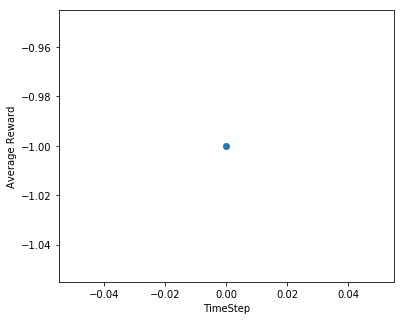

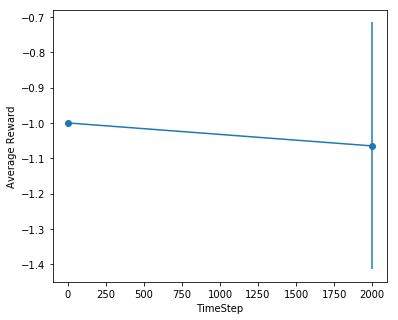

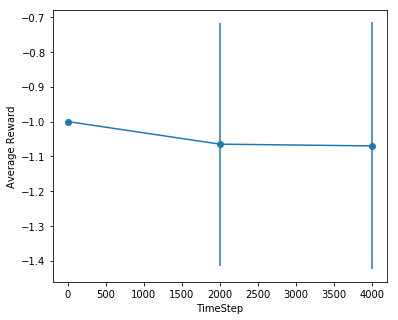

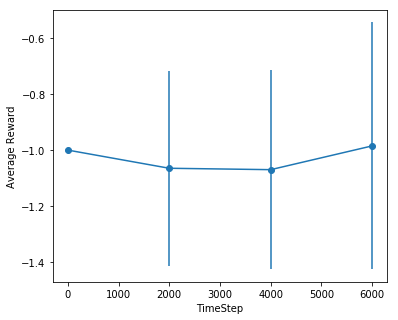

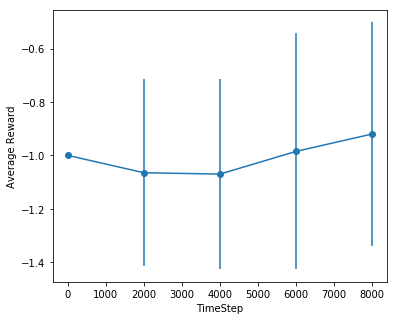

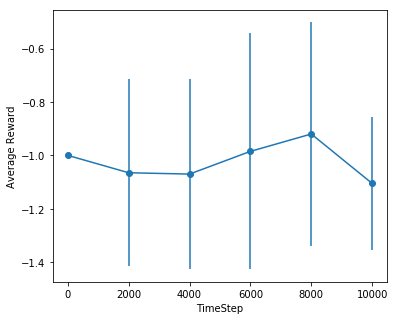

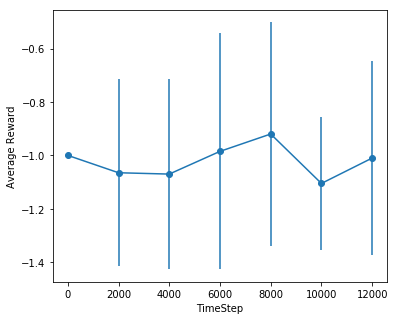

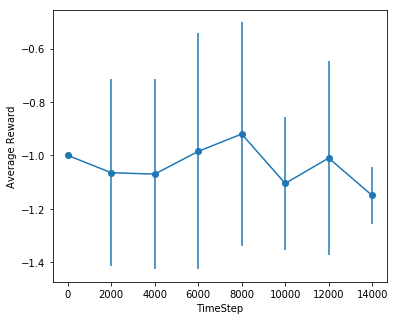

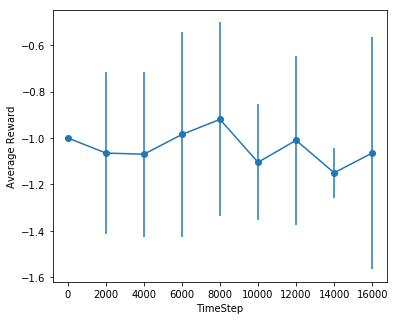

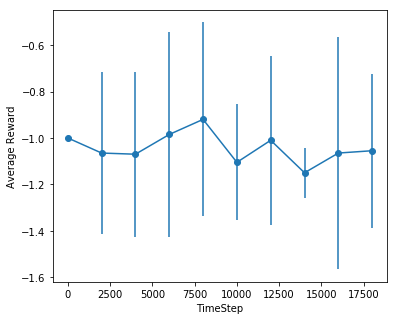

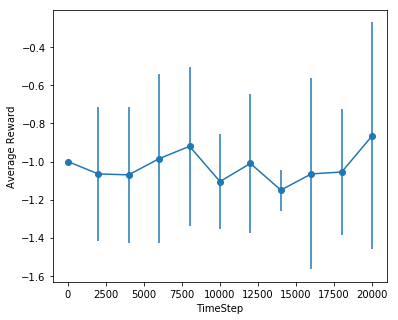

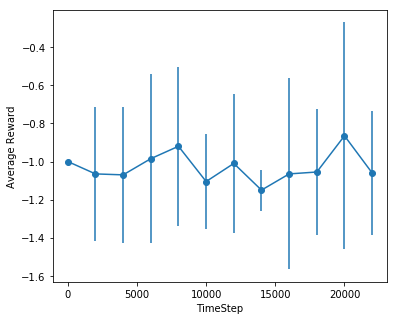

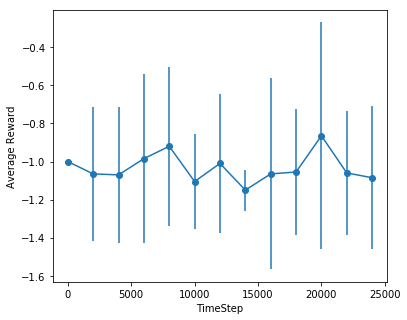

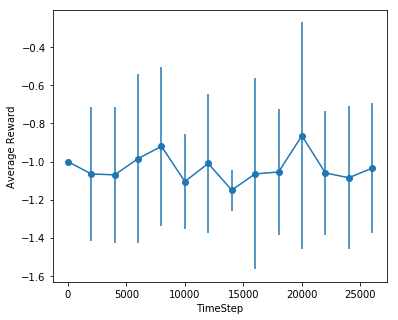

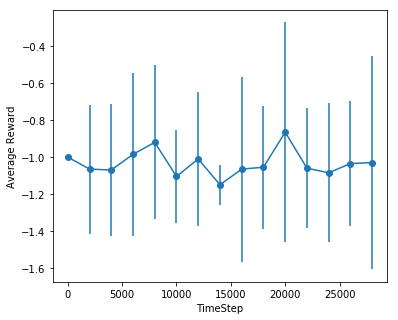

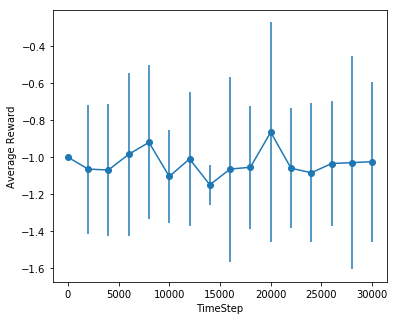

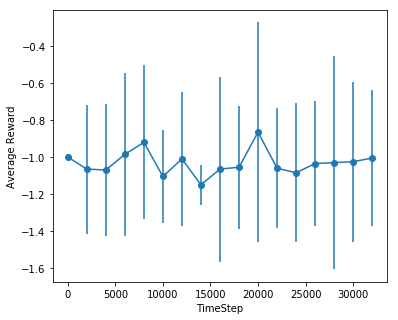

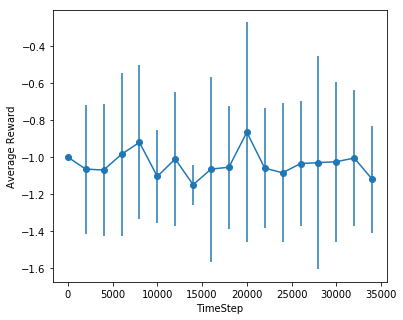

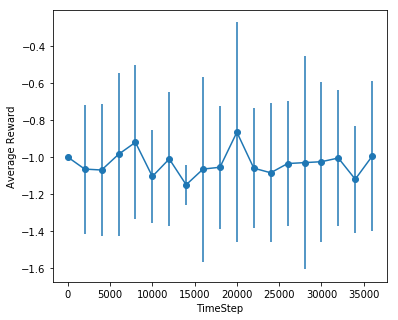

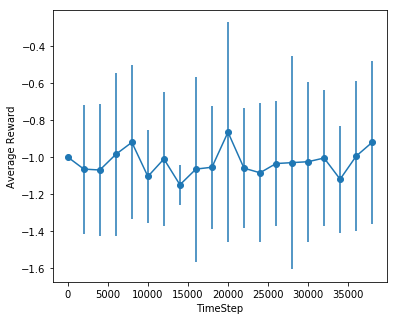

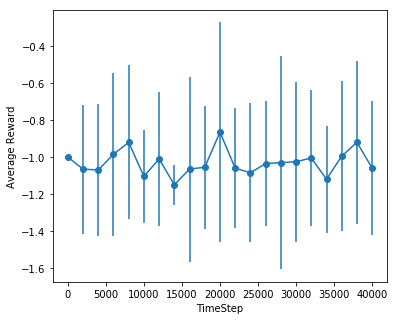

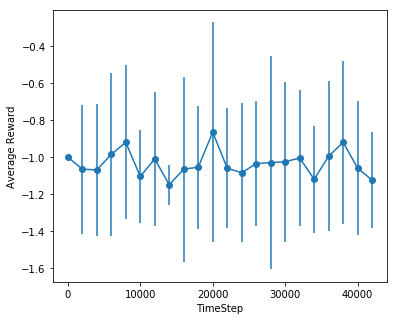

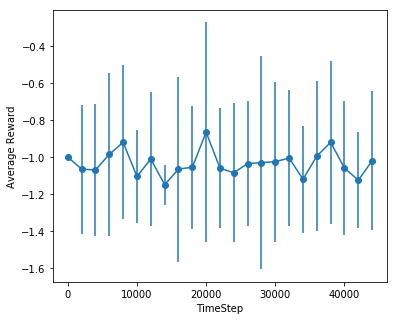

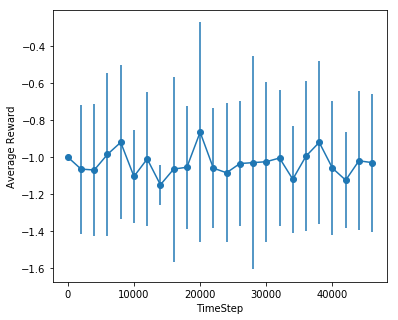

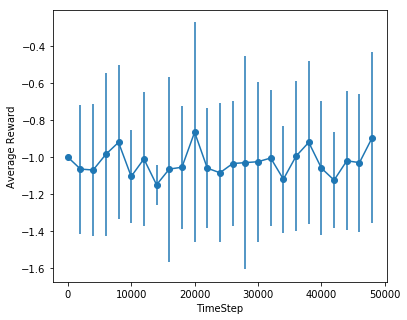

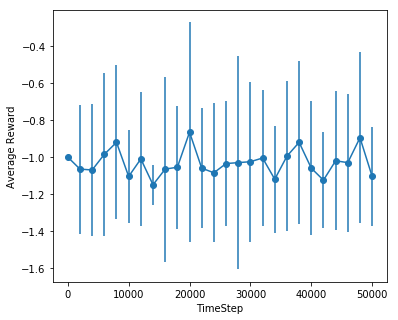

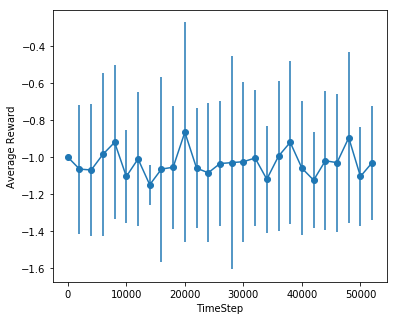

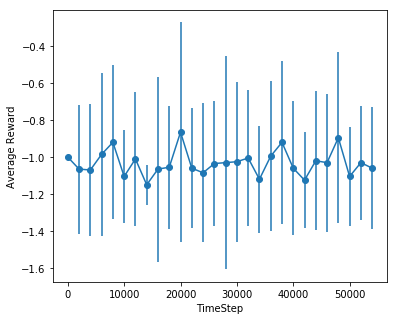

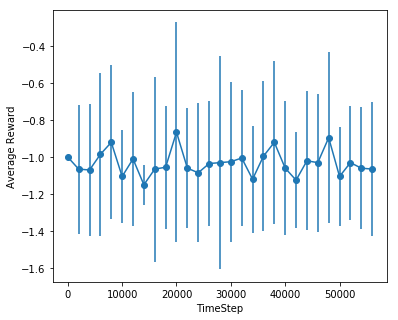

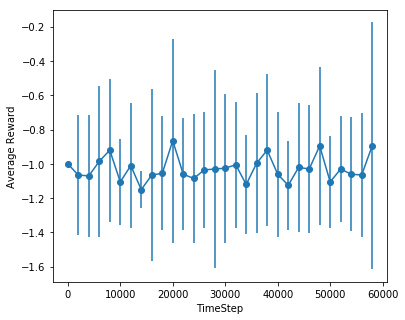

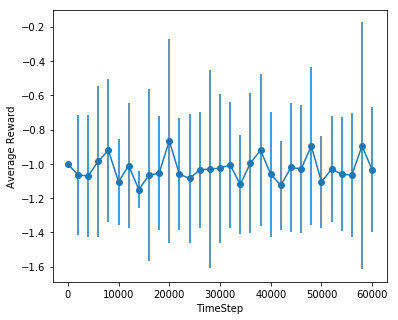

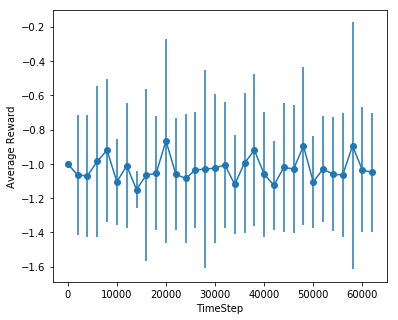

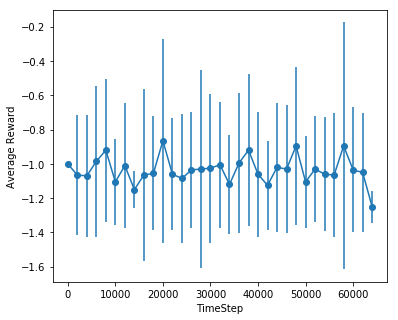

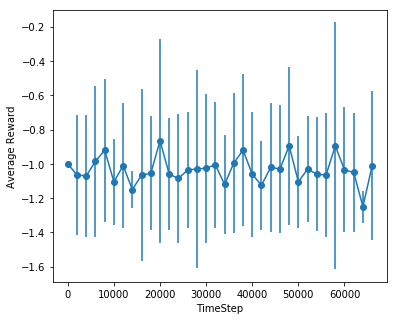

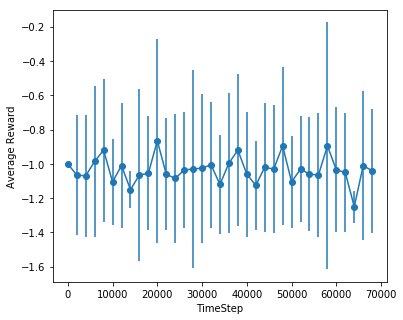

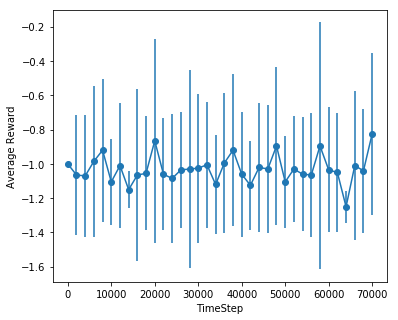

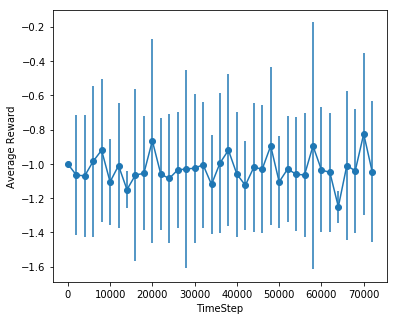

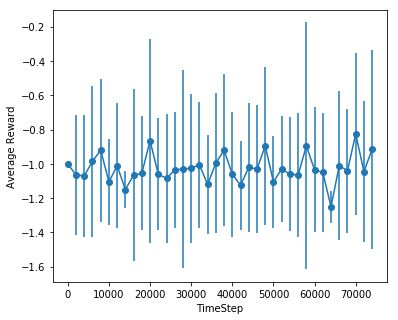

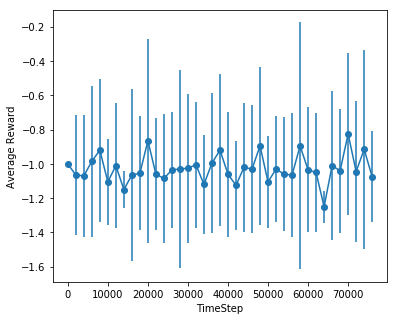

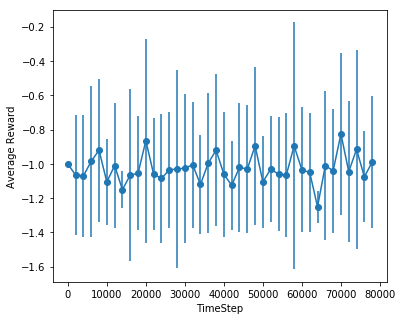

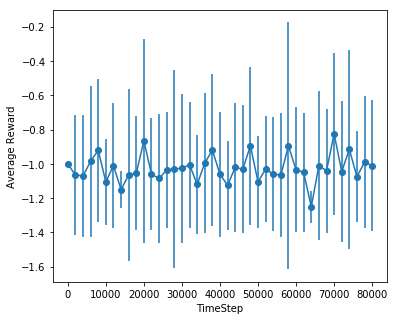

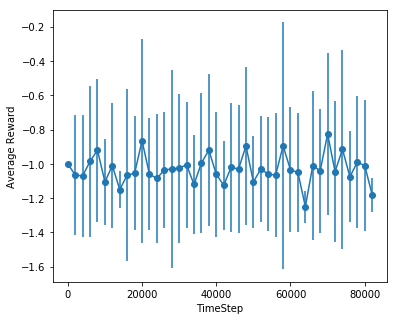

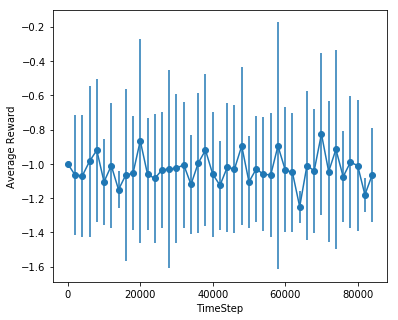

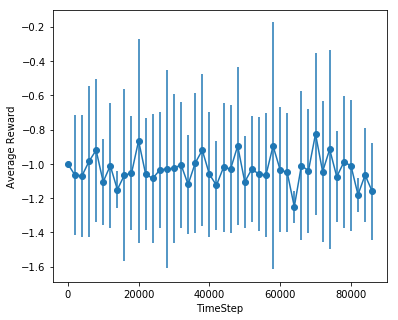

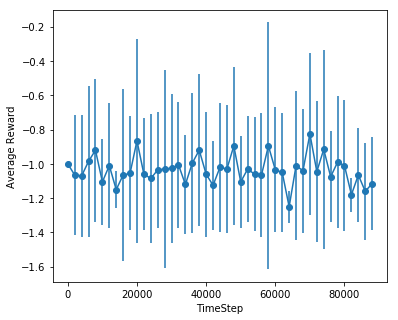

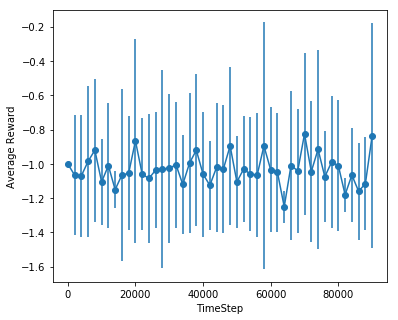

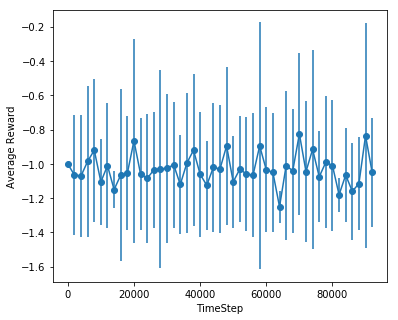

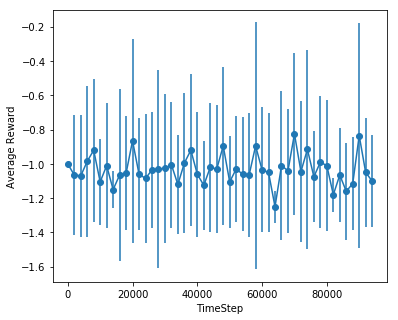

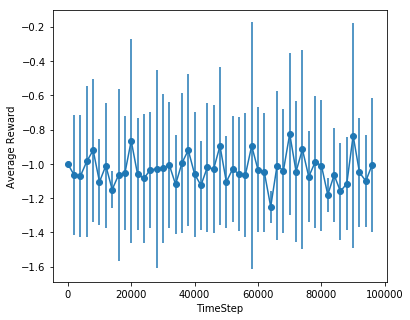

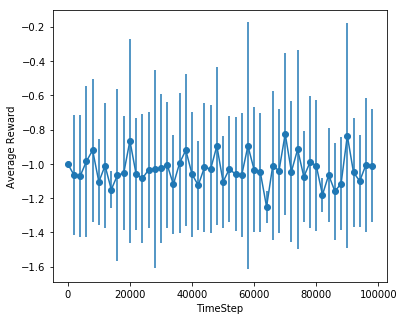

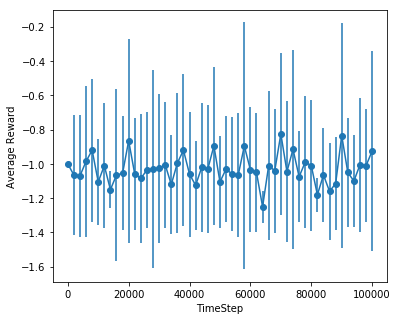

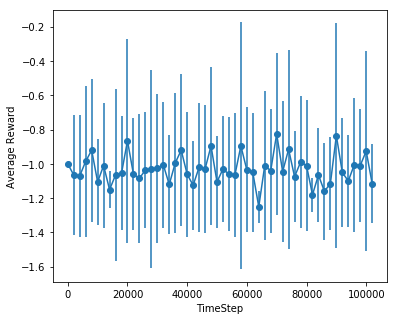

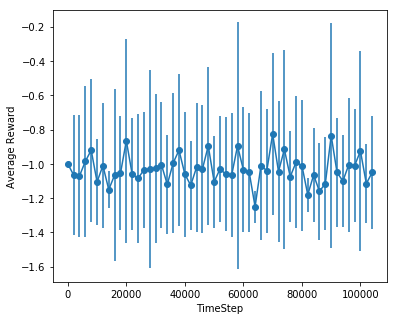

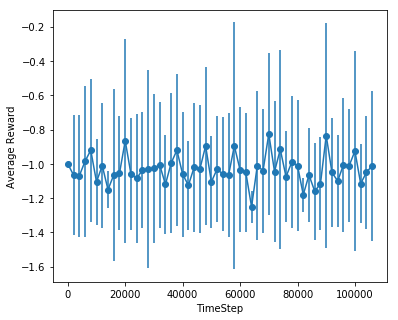

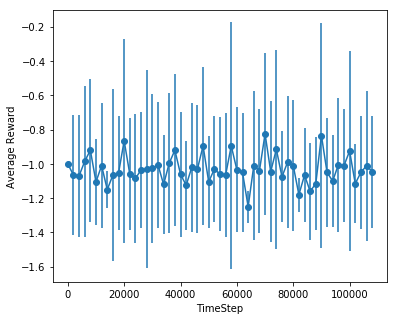

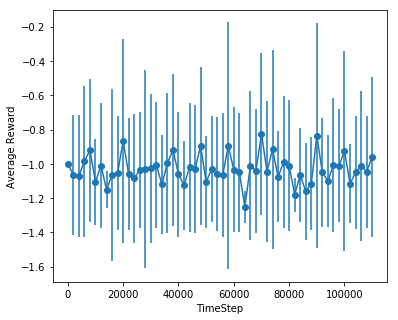

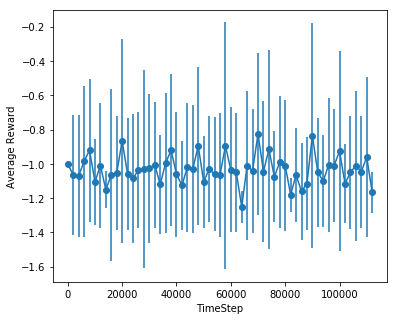

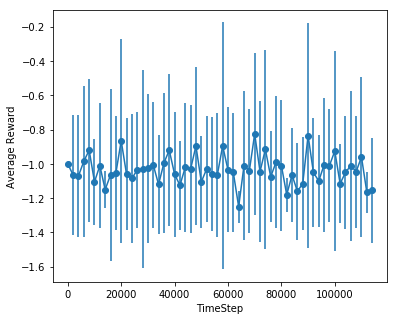

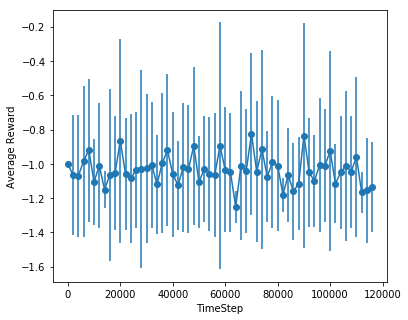

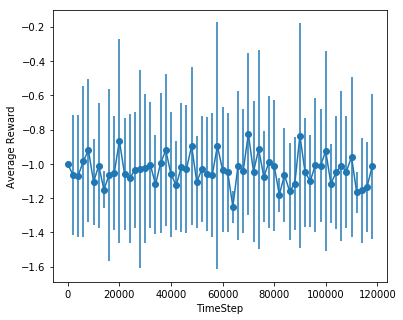

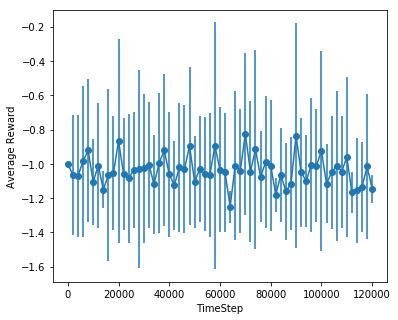

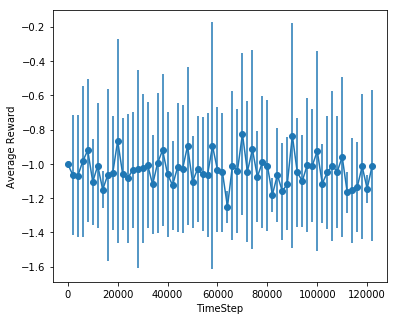

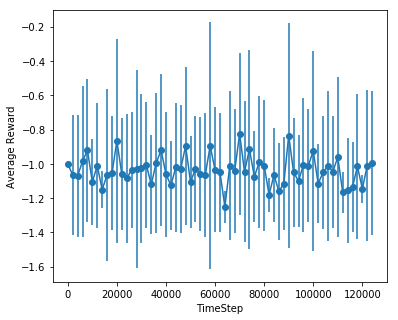

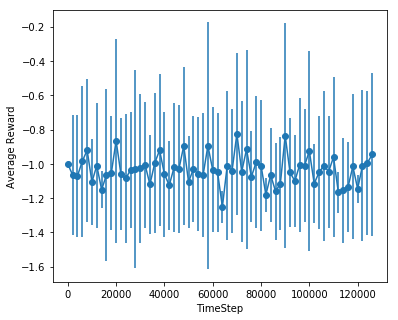

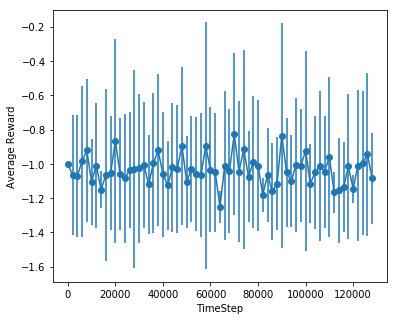

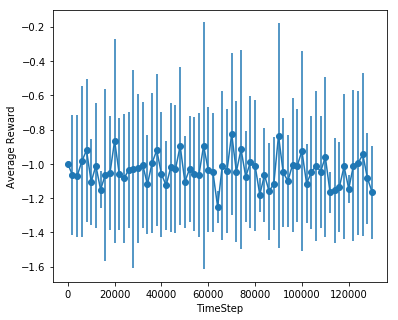

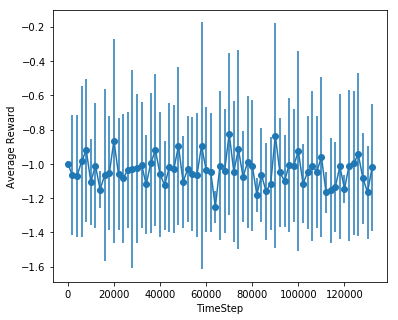

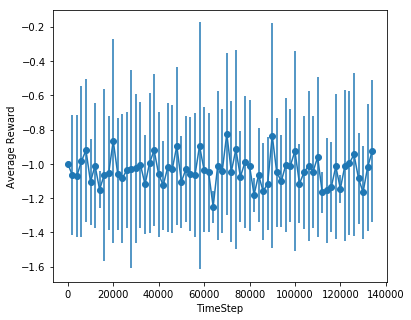

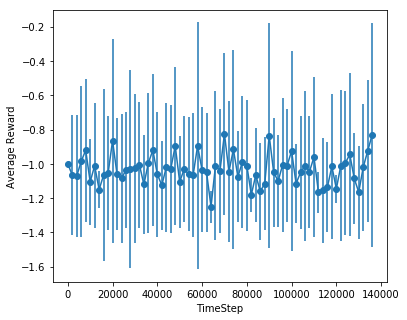

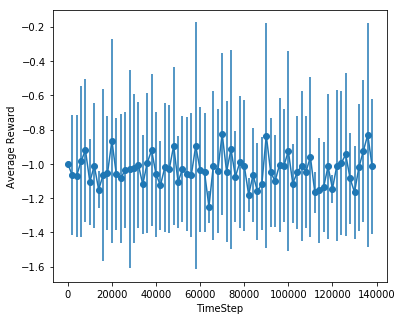

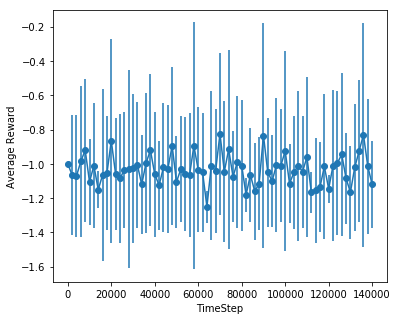

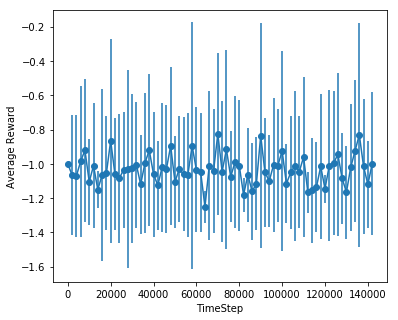

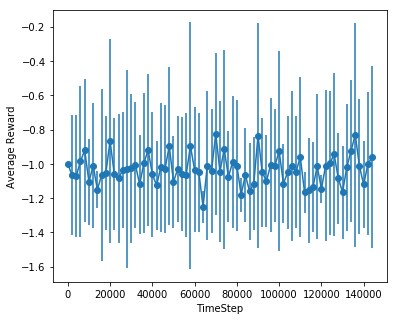

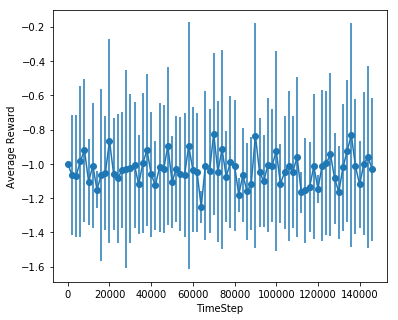

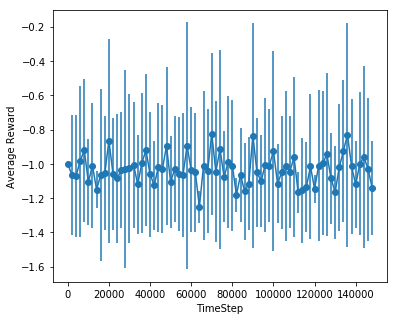

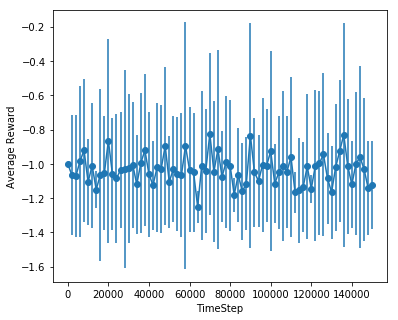

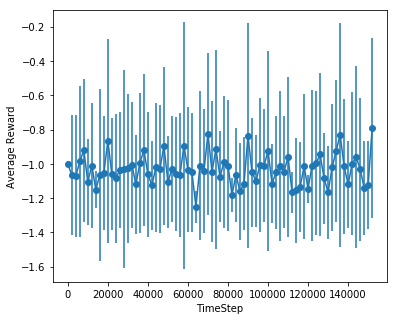

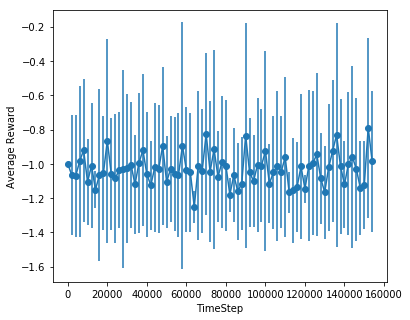

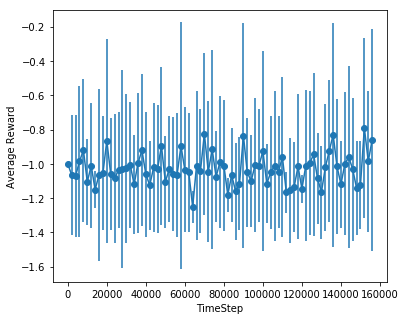

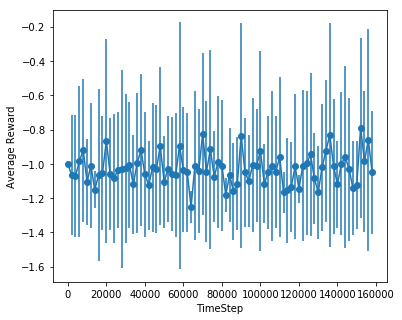

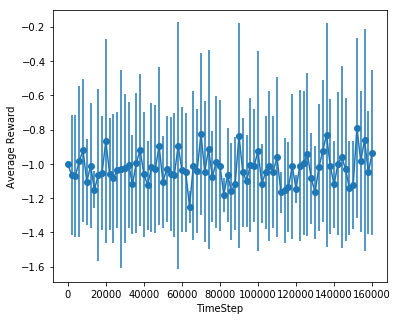

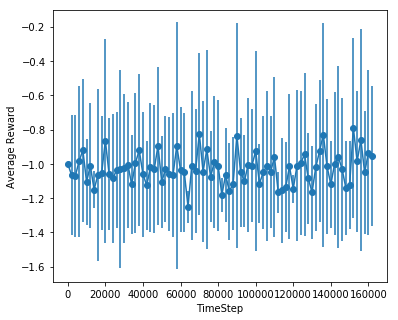

In [3]:
import sys
sys.argv=['']; del sys
parser = argparse.ArgumentParser(description='Multi-agent DDPG')

# add argument
parser.add_argument('--mo', default='train', type=str, help='support option: train/test')
# parser.add_argument('--env', default='Pendulum-v0', type=str, help='open-ai gym environment')
parser.add_argument('--hidden1', default=300, type=int, help='hidden num of first fully connect layer')
parser.add_argument('--hidden2', default=600, type=int, help='hidden num of second fully connect layer')
parser.add_argument('--Crate', default=0.001, type=float, help='learning rate')
parser.add_argument('--Arate', default=0.0001, type=float, help='policy net learning rate (only for DDPG)')
parser.add_argument('--warmup', default=100, type=int,
                    help='time without training but only filling the replay memory')
parser.add_argument('--discount', default=0.99, type=float, help='')
parser.add_argument('--batch_size', default=64, type=int, help='minibatch size')
parser.add_argument('--rmsize', default=6000000, type=int, help='memory size')
parser.add_argument('--window_length', default=1, type=int, help='')
parser.add_argument('--tau', default=0.001, type=float, help='moving average for target network')
parser.add_argument('--ou_theta', default=0.15, type=float, help='noise theta')
parser.add_argument('--ou_sigma', default=0.2, type=float, help='noise sigma')
parser.add_argument('--ou_mu', default=0.0, type=float, help='noise mu')
parser.add_argument('--validate_episodes', default=20, type=int,
                    help='how many episode to perform during validate experiment')
parser.add_argument('--max_episode_length', default=500, type=int, help='')
parser.add_argument('--validate_steps', default=2000, type=int,
                    help='how many steps to perform a validate experiment')
parser.add_argument('--output', default='output', type=str, help='')
parser.add_argument('--debug', default=True, dest='debug', action='store_true')
# parser.add_argument('--init_w', default=0.003, type=float, help='')
parser.add_argument('--train_iter', default=200000, type=int, help='train iters each timestep')
parser.add_argument('--epsilon', default=50000, type=int, help='linear decay of exploration policy')
parser.add_argument('--seed', default=-1, type=int, help='')
parser.add_argument('--resume', default='default', type=str, help='Resuming model path for testing')
# new added
parser.add_argument('--max_episode_len', default=400, type=int, help='maxepisode length')
parser.add_argument('--n_agents', default=10, type=int, help='number of agents in the environment')
parser.add_argument('--grid_size', default=6, type=int)
# parser args
args = parser.parse_args()
# set env
env = GridWorld(args=args)
n_obs = env.observation_shape
n_actions = env.action_shape
evaluate = Evaluator(args.validate_episodes, args.validate_steps, args.output,
                     max_episode_length=args.max_episode_length)
agent = MDDPG(n_obs=n_obs, n_actions=n_actions, args=args, n_states=n_obs)
if args.resume == 'default':
    args.resume = 'output/{}-run0'.format(env)

if args.mo == 'train':
    train(args.train_iter, env, evaluate, args.validate_steps, args.output,
          max_episode_length=args.max_episode_length, debug=args.debug)
elif args.mo == 'test':
    test(args.validate_episodes, agent, env, evaluate, args.resume, visualize=True, debug=args.debug)

In [ ]:
%tb